<a href="https://colab.research.google.com/github/rrl7012005/Scikit-Learn-ClassicalML-Course/blob/main/Gradient_Boosting_Machines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Gradient boosting is one of the best classical ML algorithms for any problem containing tabular data.

To use gradient boosting, use XG boost.

#Gradient Boosting

In [ ]:
!pip install opendatasets xgboost lightgbm

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import opendatasets as od
import os

##Problem Statement

Same problem as ML Problem 1:

Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality.

With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied. You are provided with historical sales data for 1,115 Rossmann stores. The task is to forecast the "Sales" column for the test set. Note that some stores in the dataset were temporarily closed for refurbishment.


In [ ]:
od.download('https://www.kaggle.com/c/rossmann-store-sales')

100%|██████████| 6.99M/6.99M [00:00<00:00, 65.9MB/s]


Extracting archive ./rossmann-store-sales/rossmann-store-sales.zip to ./rossmann-store-sales


In [ ]:
os.listdir('rossmann-store-sales')

['test.csv', 'sample_submission.csv', 'store.csv', 'train.csv']

In [ ]:
ross_df = pd.read_csv('./rossmann-store-sales/train.csv', low_memory=False)
store_df = pd.read_csv('./rossmann-store-sales/store.csv')
test_df = pd.read_csv('./rossmann-store-sales/test.csv')
submission_df = pd.read_csv('./rossmann-store-sales/sample_submission.csv')

ross_df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1
...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1


We're using the same cleaning methods as in problem 1.

In [ ]:
merged_df = ross_df.merge(store_df, how='left', on='Store')
merged_test_df = test_df.merge(store_df, how='left', on='Store')

merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Store                      1017209 non-null  int64  
 1   DayOfWeek                  1017209 non-null  int64  
 2   Date                       1017209 non-null  object 
 3   Sales                      1017209 non-null  int64  
 4   Customers                  1017209 non-null  int64  
 5   Open                       1017209 non-null  int64  
 6   Promo                      1017209 non-null  int64  
 7   StateHoliday               1017209 non-null  object 
 8   SchoolHoliday              1017209 non-null  int64  
 9   StoreType                  1017209 non-null  object 
 10  Assortment                 1017209 non-null  object 
 11  CompetitionDistance        1014567 non-null  float64
 12  CompetitionOpenSinceMonth  693861 non-null   float64
 13  CompetitionO

##Feature Engineering

We can add more features.

Lets create a function to convert the date column into datetime, and extract different parts of the date as features, we can apply functions easier.

Now model can pick up daily, weekly, monthly patterns.

In [ ]:
def split_date(df):
    df['Date'] = pd.to_datetime(df['Date'])
    df['Year'] = df.Date.dt.year
    df['Month'] = df.Date.dt.month
    df['Day'] = df.Date.dt.day
    df['WeekOfYear'] = df.Date.dt.isocalendar().week

split_date(merged_df)
split_date(merged_test_df)
merged_df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear
0,1,5,2015-07-31,5263,555,1,1,0,1,c,...,9.0,2008.0,0,NaN,NaN,NaN,2015,7,31,31
1,2,5,2015-07-31,6064,625,1,1,0,1,a,...,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",2015,7,31,31
2,3,5,2015-07-31,8314,821,1,1,0,1,a,...,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2015,7,31,31
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,...,9.0,2009.0,0,NaN,NaN,NaN,2015,7,31,31
4,5,5,2015-07-31,4822,559,1,1,0,1,a,...,4.0,2015.0,0,NaN,NaN,NaN,2015,7,31,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1,a,...,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct",2013,1,1,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1,c,...,4.0,2006.0,0,NaN,NaN,NaN,2013,1,1,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1,a,...,NaN,NaN,0,NaN,NaN,NaN,2013,1,1,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1,a,...,NaN,NaN,0,NaN,NaN,NaN,2013,1,1,1


Recall we only want the days where the store is open

In [ ]:
merged_df = merged_df[merged_df.Open == 1].copy()

From the competition columns, we can compute the number of months for which a competitor has been open near a store, using the CompetitionOpenSince columns which currently contains entries by month and year, as that is currently not useful.

In [ ]:
def comp_months(df):
  df['CompetitionOpen'] = 12 * (df.Year - df.CompetitionOpenSinceYear) + (df.Month - df.CompetitionOpenSinceMonth)
  df['CompetitionOpen'] = df['CompetitionOpen'].fillna(0).map(lambda x: 0 if x < 0 else x) #if store opened after the day of sale we set it to 0, we dont want future information

comp_months(merged_df)
comp_months(merged_test_df)

merged_df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear,CompetitionOpen
0,1,5,2015-07-31,5263,555,1,1,0,1,c,...,2008.0,0,NaN,NaN,NaN,2015,7,31,31,82.0
1,2,5,2015-07-31,6064,625,1,1,0,1,a,...,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",2015,7,31,31,92.0
2,3,5,2015-07-31,8314,821,1,1,0,1,a,...,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2015,7,31,31,103.0
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,...,2009.0,0,NaN,NaN,NaN,2015,7,31,31,70.0
4,5,5,2015-07-31,4822,559,1,1,0,1,a,...,2015.0,0,NaN,NaN,NaN,2015,7,31,31,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016776,682,2,2013-01-01,3375,566,1,0,a,1,b,...,2006.0,0,NaN,NaN,NaN,2013,1,1,1,76.0
1016827,733,2,2013-01-01,10765,2377,1,0,a,1,b,...,1999.0,0,NaN,NaN,NaN,2013,1,1,1,159.0
1016863,769,2,2013-01-01,5035,1248,1,0,a,1,b,...,NaN,1,48.0,2012.0,"Jan,Apr,Jul,Oct",2013,1,1,1,0.0
1017042,948,2,2013-01-01,4491,1039,1,0,a,1,b,...,NaN,0,NaN,NaN,NaN,2013,1,1,1,0.0


We can also add some additional columns to indicate how long a store has been running Promo2 and whether a new round of Promo2 starts in the current month.

Promo Interval tells whenever the promo was kicked off (see table).

The first function checks whether the current month is a promotion month.

In [ ]:
def check_promo_month(row):
  month2str = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun',
                 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}

  try:
    months = (row['PromoInterval'] or '').split(',')
    if row['Promo2Open'] and month2str[row['Month']] in months:
      return 1
    else:
      return 0
  except Exception:
    return 0

def promo_cols(df):
    # Months since Promo2 was open
    df['Promo2Open'] = 12 * (df.Year - df.Promo2SinceYear) +  (df.WeekOfYear - df.Promo2SinceWeek)*7/30.5
    df['Promo2Open'] = df['Promo2Open'].fillna(0).map(lambda x: 0 if x < 0 else x)
    df['Promo2Open'] = df['Promo2Open'] * df['Promo2'] #0 if no promo
    # Whether a new round of promotions was started in the current month
    df['IsPromo2Month'] = df.apply(check_promo_month, axis=1) * df['Promo2']
    return df

promo_cols(merged_df)
promo_cols(merged_test_df)

merged_df[['Date', 'Promo2', 'Promo2SinceYear', 'Promo2SinceWeek', 'PromoInterval', 'Promo2Open', 'IsPromo2Month']].sample(20)

,Date,Promo2,Promo2SinceYear,Promo2SinceWeek,PromoInterval,Promo2Open,IsPromo2Month
119120,2015-04-16,1,2012.0,1.0,"Jan,Apr,Jul,Oct",39.442623,1
531522,2014-03-12,0,NaN,NaN,NaN,0.000000,0
343889,2014-09-08,1,2014.0,10.0,"Mar,Jun,Sept,Dec",6.196721,1
967966,2013-02-14,1,2010.0,13.0,"Jan,Apr,Jul,Oct",34.622951,0
12483,2015-07-20,0,NaN,NaN,NaN,0.000000,0
327266,2014-09-25,0,NaN,NaN,NaN,0.000000,0
23026,2015-07-11,0,NaN,NaN,NaN,0.000000,0
686447,2013-10-24,0,NaN,NaN,NaN,0.000000,0
551478,2014-02-22,1,2013.0,10.0,"Mar,Jun,Sept,Dec",11.540984,0
647583,2013-11-28,0,NaN,NaN,NaN,0.000000,0


##Preprocessing

In [ ]:
merged_df.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval', 'Year', 'Month', 'Day',
       'WeekOfYear', 'CompetitionOpen', 'Promo2Open', 'IsPromo2Month'],
      dtype='object')

In [ ]:
input_cols = ['Store', 'DayOfWeek', 'Promo', 'StateHoliday', 'SchoolHoliday',
              'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpen',
              'Day', 'Month', 'Year', 'WeekOfYear',  'Promo2',
              'Promo2Open', 'IsPromo2Month']
target_col = 'Sales'

inputs = merged_df[input_cols].copy()
targets = merged_df[target_col].copy()
test_inputs = merged_test_df[input_cols].copy()

numeric_cols = ['Store', 'Promo', 'SchoolHoliday',
              'CompetitionDistance', 'CompetitionOpen', 'Promo2', 'Promo2Open', 'IsPromo2Month',
              'Day', 'Month', 'Year', 'WeekOfYear',  ]
categorical_cols = ['DayOfWeek', 'StateHoliday', 'StoreType', 'Assortment']

Impute

In [ ]:
inputs[numeric_cols].isna().sum()

,0
Store,0
Promo,0
SchoolHoliday,0
CompetitionDistance,2186
CompetitionOpen,0
Promo2,0
Promo2Open,0
IsPromo2Month,0
Day,0
Month,0


In [ ]:
test_inputs[numeric_cols].isna().sum()

,0
Store,0
Promo,0
SchoolHoliday,0
CompetitionDistance,96
CompetitionOpen,0
Promo2,0
Promo2Open,0
IsPromo2Month,0
Day,0
Month,0


Competition distance is the only column with NaNs so what we could do is fill it with the highest value we can find to indicate the competition is very far away.

In [ ]:
max_distance = inputs.CompetitionDistance.max()
inputs['CompetitionDistance'].fillna(max_distance*2, inplace=True)
test_inputs['CompetitionDistance'].fillna(max_distance*2, inplace=True)

Scale and encode

In [ ]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

scaler = MinMaxScaler().fit(inputs[numeric_cols])

inputs[numeric_cols] = scaler.transform(inputs[numeric_cols])
test_inputs[numeric_cols] = scaler.transform(test_inputs[numeric_cols])

encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore').fit(inputs[categorical_cols])
encoded_cols = list(encoder.get_feature_names_out(categorical_cols))

inputs[encoded_cols] = encoder.transform(inputs[categorical_cols])
test_inputs[encoded_cols] = encoder.transform(test_inputs[categorical_cols])

X = inputs[numeric_cols + encoded_cols]
X_test = test_inputs[numeric_cols + encoded_cols]

X

,Store,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpen,Promo2,Promo2Open,IsPromo2Month,Day,Month,...,StateHoliday_a,StateHoliday_b,StateHoliday_c,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c
0,0.000000,1.0,1.0,0.008240,0.059163,0.0,0.000000,0.0,1.0,0.545455,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,0.000898,1.0,1.0,0.003626,0.066378,1.0,0.890710,1.0,1.0,0.545455,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.001795,1.0,1.0,0.093013,0.074315,1.0,0.720856,1.0,1.0,0.545455,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.002693,1.0,1.0,0.003955,0.050505,0.0,0.000000,0.0,1.0,0.545455,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,0.003591,1.0,1.0,0.197034,0.002165,0.0,0.000000,0.0,1.0,0.545455,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016776,0.611311,0.0,1.0,0.000857,0.054834,0.0,0.000000,0.0,0.0,0.000000,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1016827,0.657092,0.0,1.0,0.005537,0.114719,0.0,0.000000,0.0,0.0,0.000000,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1016863,0.689408,0.0,1.0,0.005405,0.000000,1.0,0.016849,1.0,0.0,0.000000,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1017042,0.850090,0.0,1.0,0.009295,0.000000,0.0,0.000000,0.0,0.0,0.000000,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


We didn't create a validation set yet as we will use KFold cross validation, which is explained in ML Problem 1.

##Training with GBMs

Gradient boosting machines works as follows for a regressor:

1. The mean value of the target column is used as an initial prediction for every input.
2. The residuals (difference) of the predictions with the targets are computed.
3. A decision tree of limited depth is trained to just predict the residuals for each input
4. Predictions from the decision tree are scaled using a parameter called the learning rate (to prevent overfitting)
5. The scaled predictions for the tree are added to the previous predictions to obtain the new and improved predictions.
6. Steps 2 to 5 are repeated.

Too many repetitions = overfitting.
It has gradient in it as each decision tree is trained to reduce the loss from the previous iteration (similar to gradient descent). Its called boosting as we improve the results of a decision tree model.  max_depth is depth of each tree. n_estimators is total number of iterations.


There is a GBM in scikit learn but XGboost is  far more efficient and versatile.

In [ ]:
from xgboost import XGBRegressor

model = XGBRegressor(objective='reg:squarederror', random_state=42,
                     learning_rate=0.3, max_depth=4, n_estimators=20, n_jobs=-1,
                     verbosity=1)

model.fit(X, targets)

preds = model.predict(X)
from sklearn.metrics import mean_squared_error

def rmse(a, b):
    return mean_squared_error(a, b, squared=False)

rmse(targets, preds)

2357.1278101525777

Not bad but still not as good as our random forest.

##Visualize Trees and Postprocessing

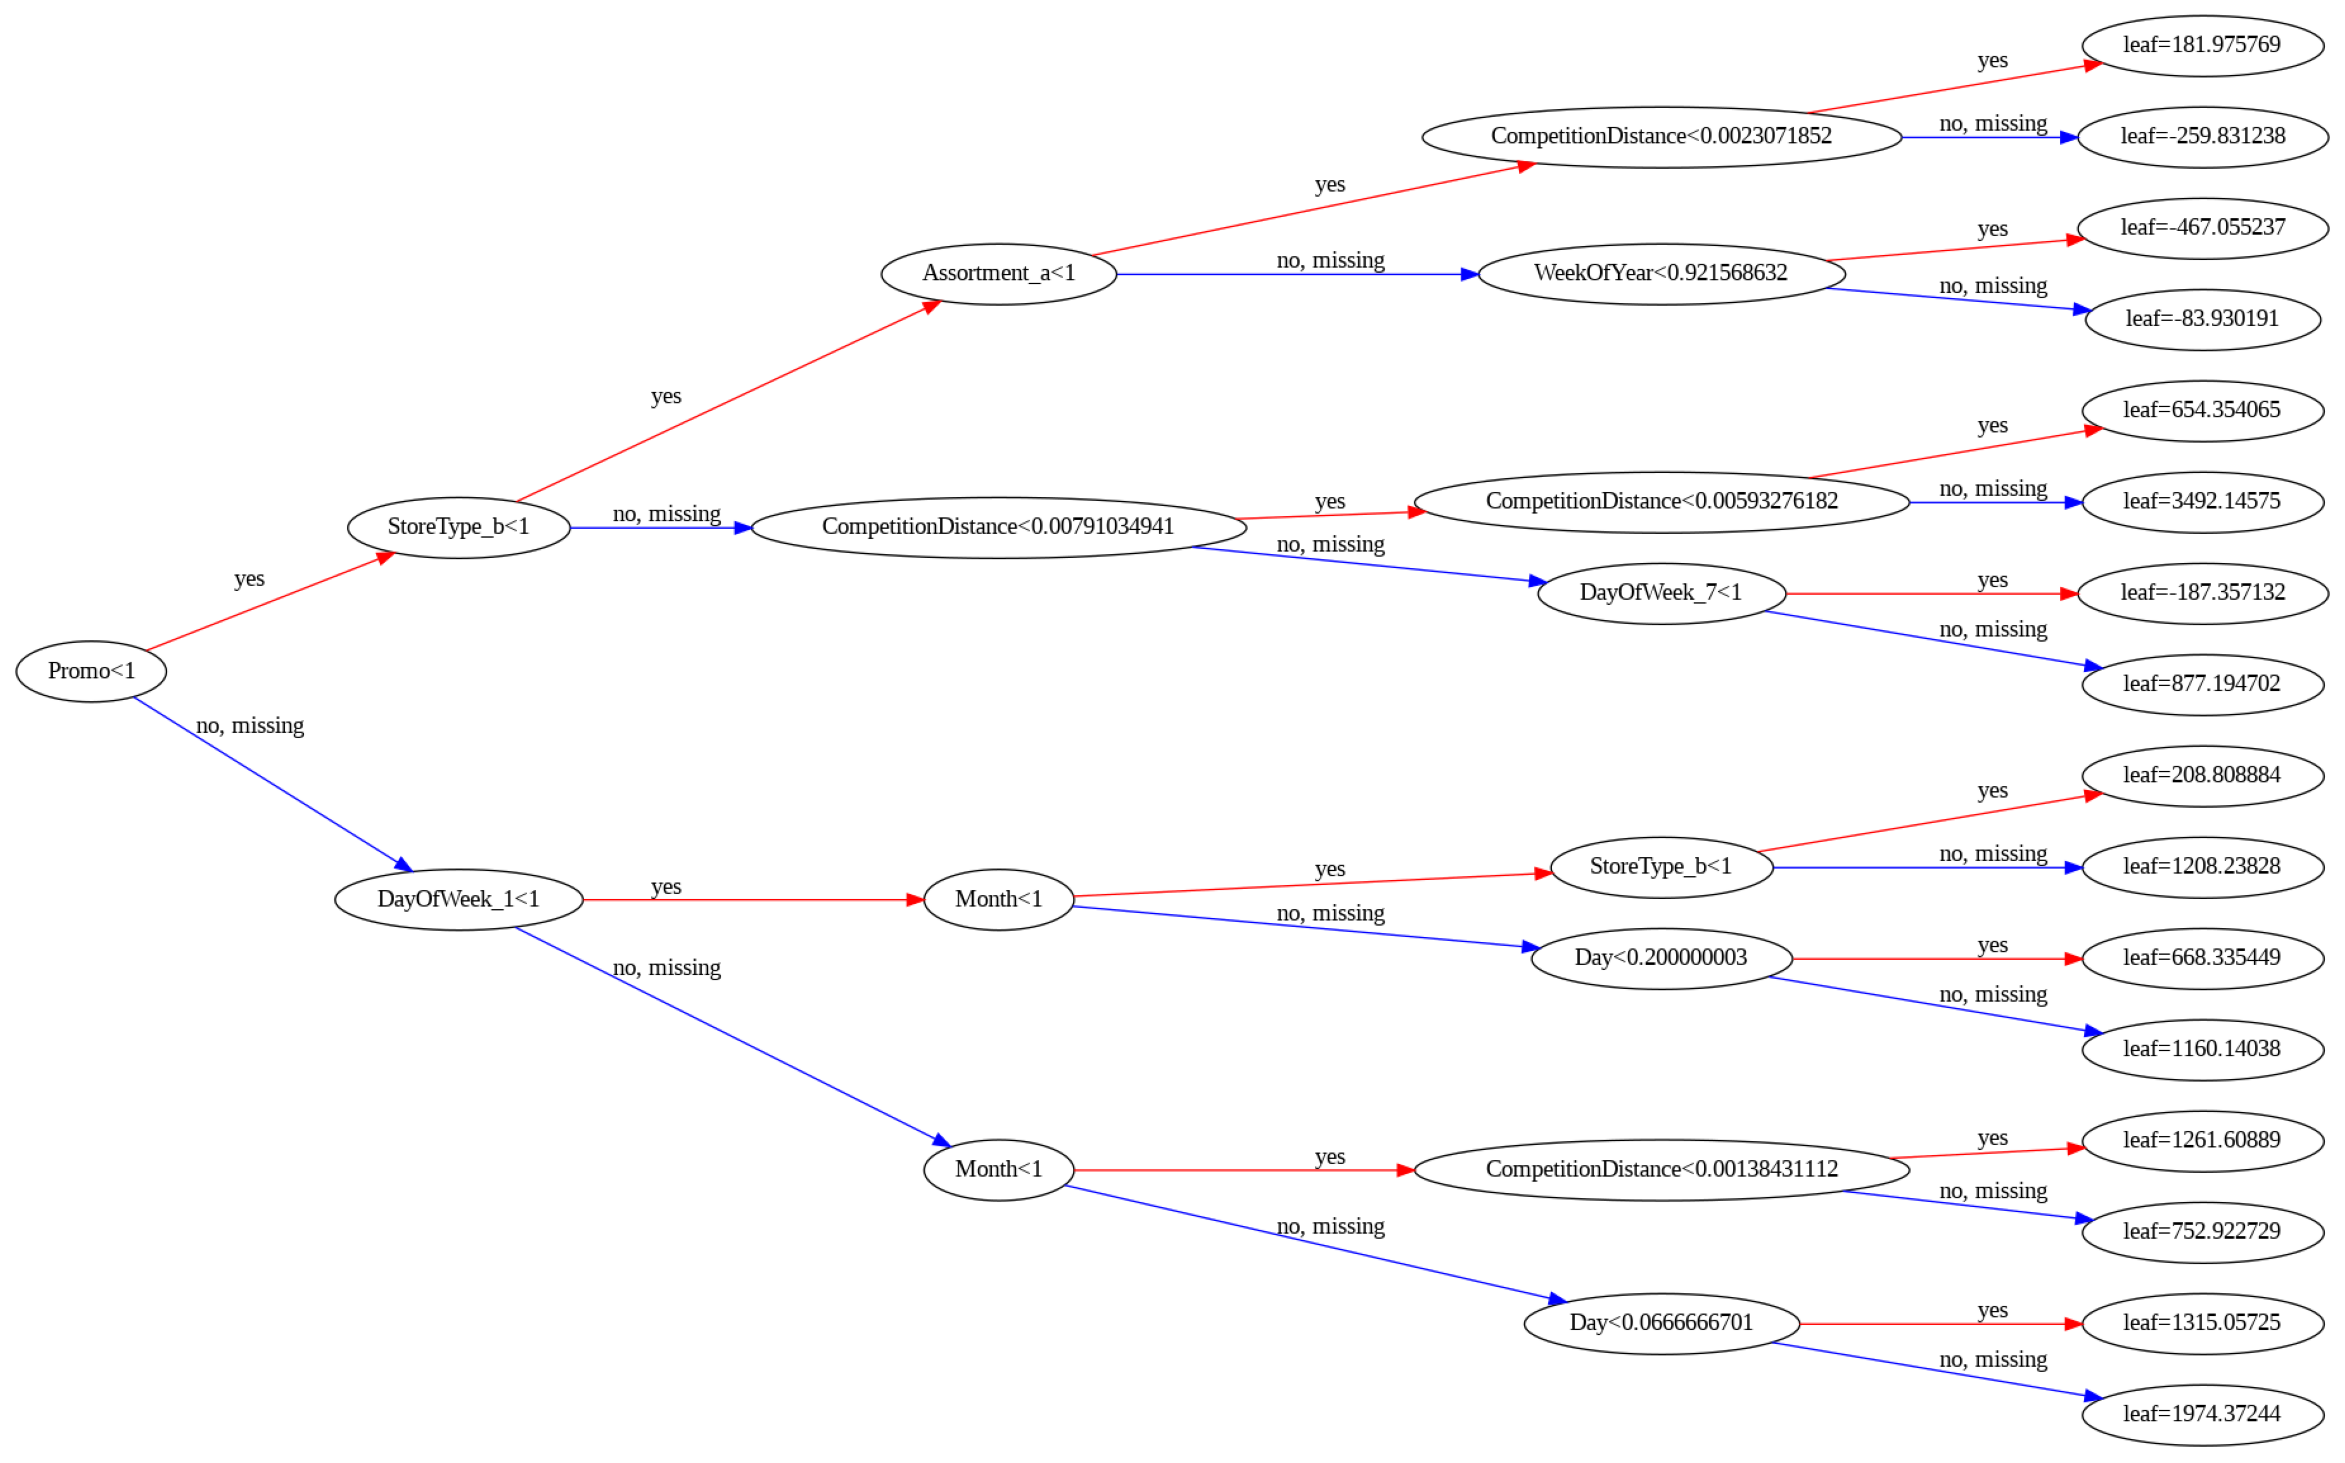

In [ ]:
from xgboost import plot_tree
from matplotlib.pylab import rcParams

rcParams['figure.figsize'] = 30,30
plot_tree(model, rankdir='LR'); #left to right

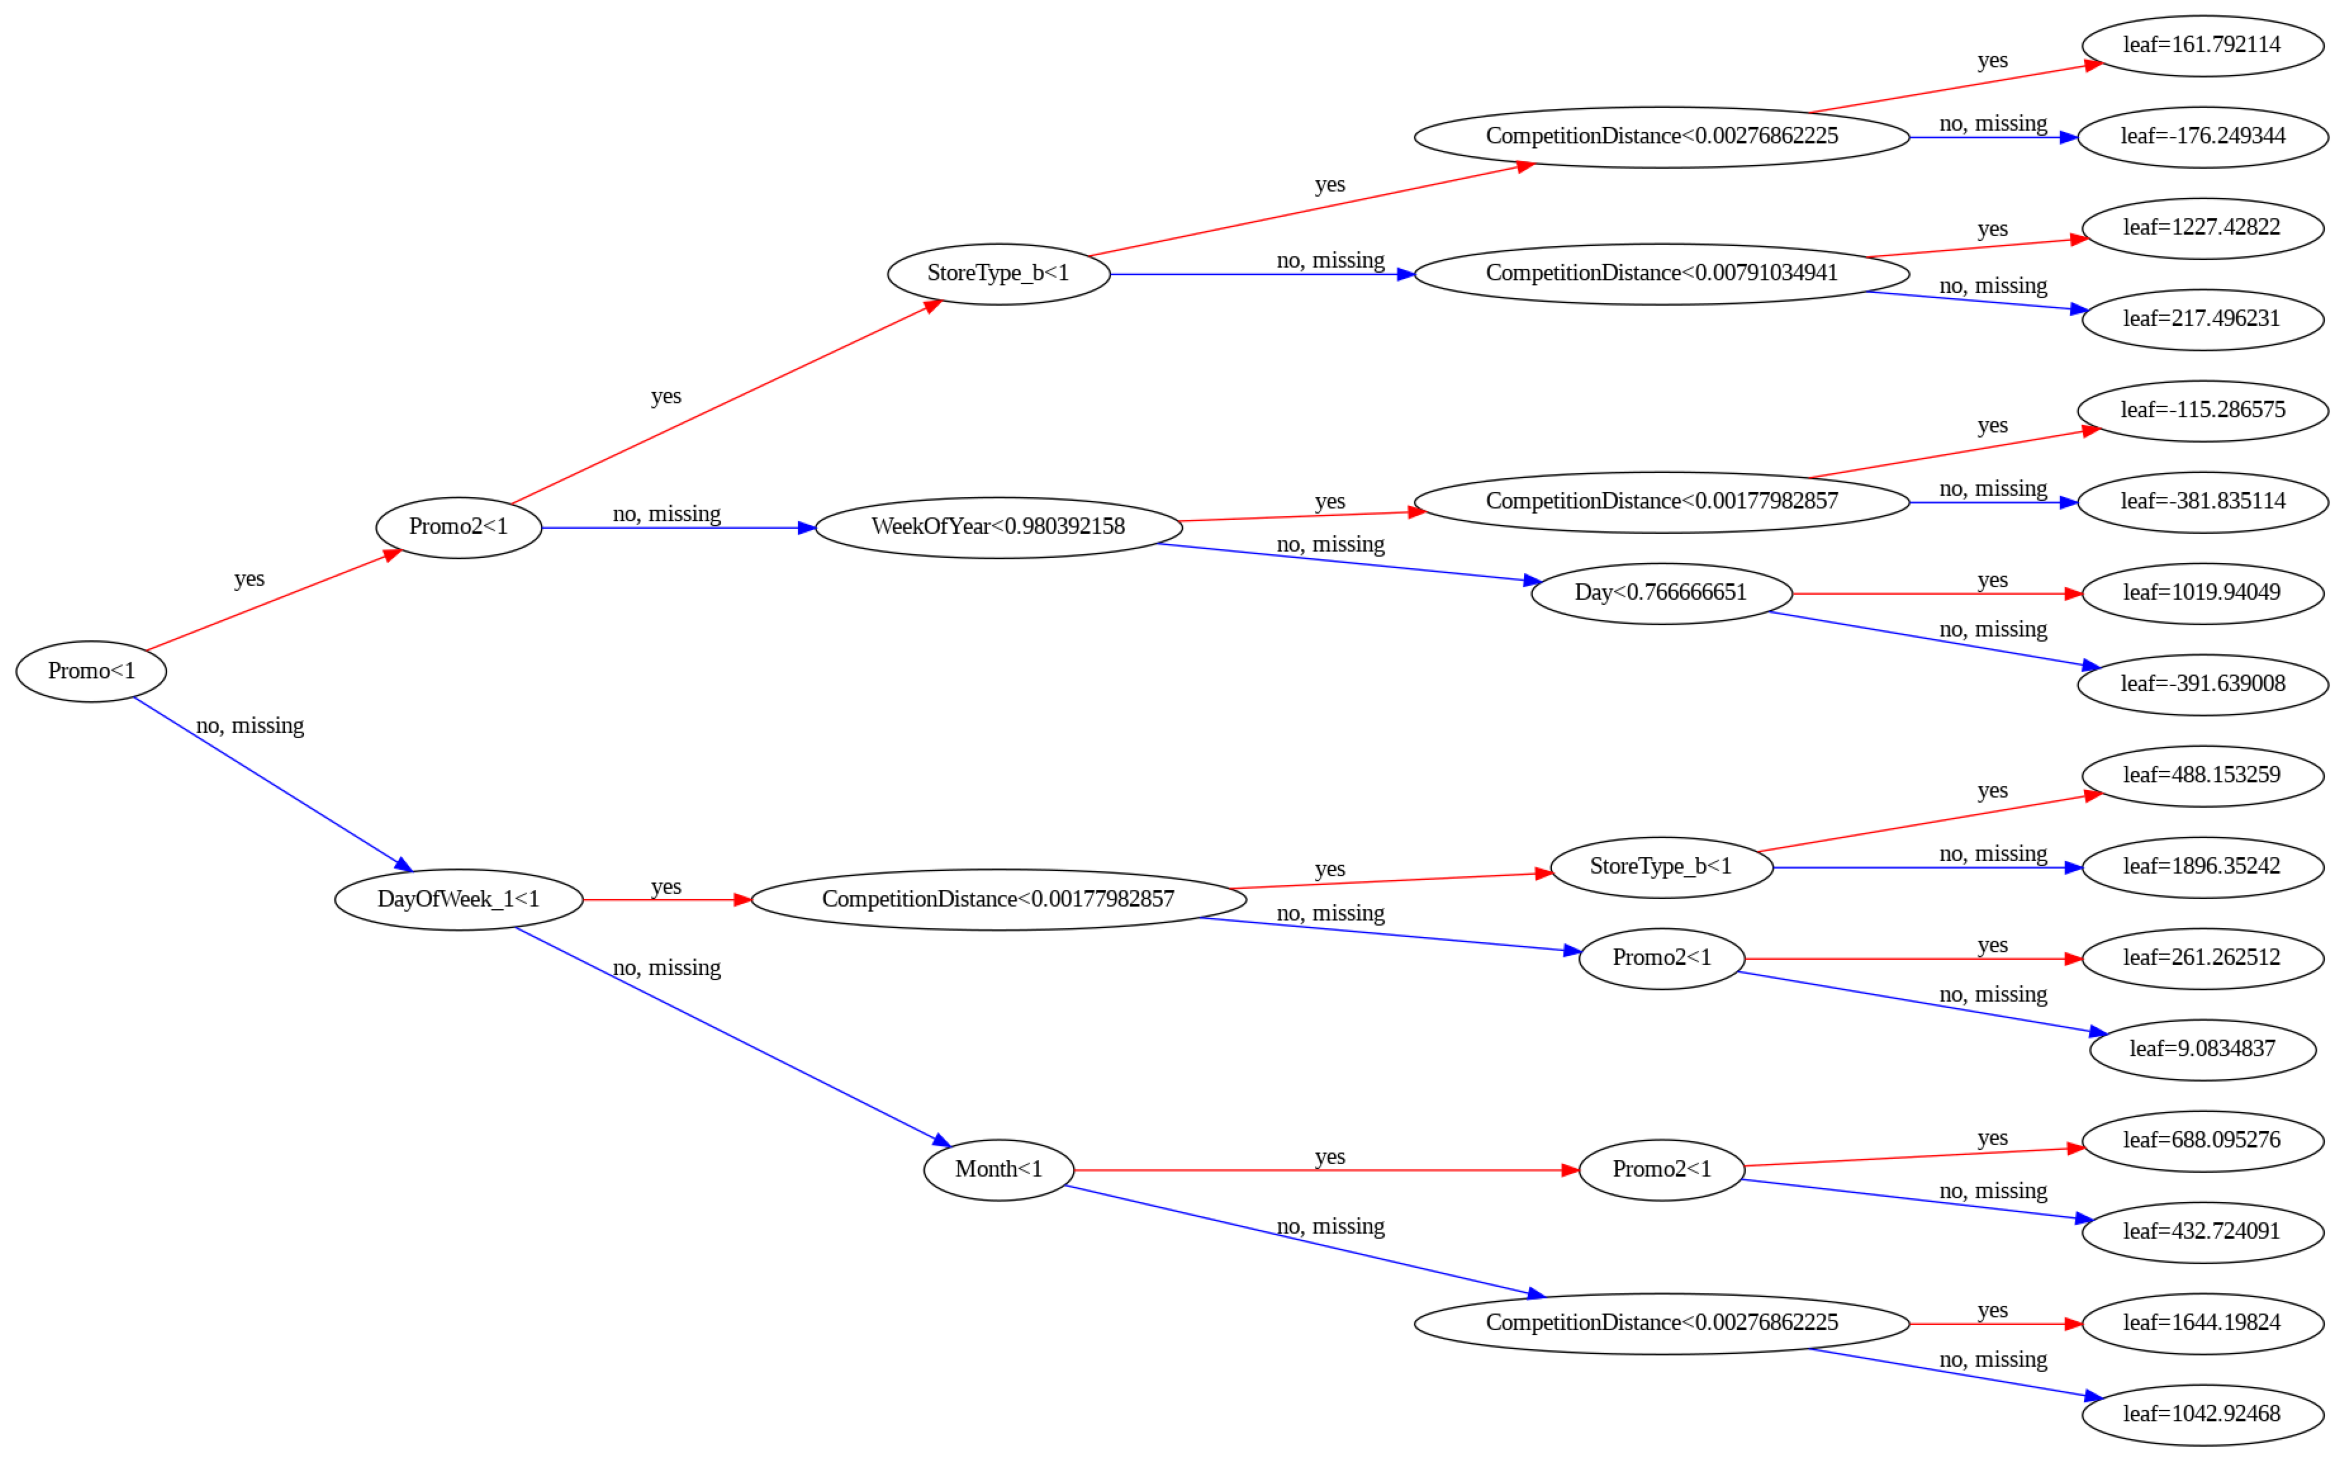

In [ ]:
plot_tree(model, rankdir='LR', num_trees=1); #which tree you want to plot

Visualize the tree as text

In [ ]:
trees = model.get_booster().get_dump()
len(trees), print(trees[0])

0:[Promo<1] yes=1,no=2,missing=2
	1:[StoreType_b<1] yes=3,no=4,missing=4
		3:[Assortment_a<1] yes=7,no=8,missing=8
			7:[CompetitionDistance<0.0023071852] yes=15,no=16,missing=16
				15:leaf=181.975769
				16:leaf=-259.831238
			8:[WeekOfYear<0.921568632] yes=17,no=18,missing=18
				17:leaf=-467.055237
				18:leaf=-83.930191
		4:[CompetitionDistance<0.00791034941] yes=9,no=10,missing=10
			9:[CompetitionDistance<0.00593276182] yes=19,no=20,missing=20
				19:leaf=654.354065
				20:leaf=3492.14575
			10:[DayOfWeek_7<1] yes=21,no=22,missing=22
				21:leaf=-187.357132
				22:leaf=877.194702
	2:[DayOfWeek_1<1] yes=5,no=6,missing=6
		5:[Month<1] yes=11,no=12,missing=12
			11:[StoreType_b<1] yes=23,no=24,missing=24
				23:leaf=208.808884
				24:leaf=1208.23828
			12:[Day<0.200000003] yes=25,no=26,missing=26
				25:leaf=668.335449
				26:leaf=1160.14038
		6:[Month<1] yes=13,no=14,missing=14
			13:[CompetitionDistance<0.00138431112] yes=27,no=28,missing=28
				27:leaf=1261.60889
				28:leaf=752

(20, None)

feature importance is also provided by XGBoost.

In [ ]:
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)
importance_df.head(10)

,feature,importance
1,Promo,0.309244
12,DayOfWeek_1,0.076455
26,StoreType_d,0.071732
24,StoreType_b,0.066487
5,Promo2,0.040490
3,CompetitionDistance,0.039816
27,Assortment_a,0.038316
25,StoreType_c,0.036829
4,CompetitionOpen,0.034157
9,Month,0.026813


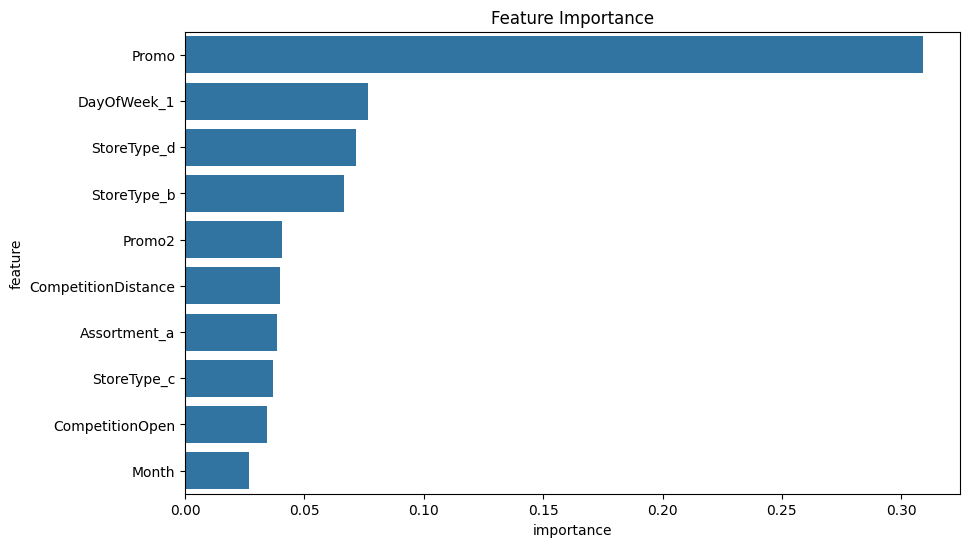

In [ ]:
import seaborn as sns
plt.figure(figsize=(10,6))
plt.title('Feature Importance')
sns.barplot(data=importance_df.head(10), x='importance', y='feature');

##Hyperameter Tuning

**K-fold cross validation**

Our validation set should ideally be as reflective of the test set as possible, and iur test set is in the future so our validation set should be ahead of the test set. Therefore this is a downside of k-fold validation for time series data, but that does not matter for non-time series data. So this may not be optimal.

In [ ]:
from sklearn.model_selection import KFold

#Define a helper fuction to train and evaluate

def train_and_evaluate(X_train, train_targets, X_val, val_targets, **params):
    model = XGBRegressor(random_state=42, n_jobs=-1, **params)
    model.fit(X_train, train_targets)
    train_rmse = rmse(model.predict(X_train), train_targets)
    val_rmse = rmse(model.predict(X_val), val_targets)
    return model, train_rmse, val_rmse

kfold = KFold(n_splits=5) #create the model\

#This is how to apply it

models = []

#kfold.split gives list of indexes as validation rows and list of indexes as training rows

for train_idxs, val_idxs in kfold.split(X): #give data you want to split
    X_train, train_targets = X.iloc[train_idxs], targets.iloc[train_idxs] #grab rows
    X_val, val_targets = X.iloc[val_idxs], targets.iloc[val_idxs]
    model, train_rmse, val_rmse = train_and_evaluate(X_train, train_targets,
                                                     X_val, val_targets,
                                                     max_depth=4, n_estimators=20)
    models.append(model)
    print(f"TRAIN RMSE: {train_rmse}, Validation RMSE: {val_rmse}")

TRAIN RMSE: 2370.7136430479463, Validation RMSE: 2448.739998478758
TRAIN RMSE: 2376.830658491627, Validation RMSE: 2413.5622536102155
TRAIN RMSE: 2386.944071778845, Validation RMSE: 2364.856120007352
TRAIN RMSE: 2348.3401652445446, Validation RMSE: 2458.1552579968957
TRAIN RMSE: 2370.9691440768092, Validation RMSE: 2441.7500928714353


Lets define a function to average predictions from the 5 models. Currently all models for each set combination is the same parameters but have different datasets, so the rmse is still similar. K-fold is used if the dataset is not too large.

In [ ]:
def predict_avg(models, inputs):
    return np.mean([model.predict(inputs) for model in models], axis=0)

preds = predict_avg(models, X)
rmse(preds, targets)

2363.1014601001366

**Hyperparameter tuning**

Create a helper function

In [ ]:
def test_params_kfold(n_splits, **params):
    train_rmses, val_rmses, models = [], [], []
    kfold = KFold(n_splits)
    for train_idxs, val_idxs in kfold.split(X):
        X_train, train_targets = X.iloc[train_idxs], targets.iloc[train_idxs]
        X_val, val_targets = X.iloc[val_idxs], targets.iloc[val_idxs]
        model, train_rmse, val_rmse = train_and_evaluate(X_train, train_targets, X_val, val_targets, **params)
        models.append(model)
        train_rmses.append(train_rmse)
        val_rmses.append(val_rmse)
    print('Train RMSE: {}, Validation RMSE: {}'.format(np.mean(train_rmses), np.mean(val_rmses)))
    return models

Now it may take a long time to do 5-fold cross validation for each set of parameters we want to try so we'll just pick a random 10% of the dataset as our validation to speed things up, instead of k-fold.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, train_targets, val_targets = train_test_split(X, targets, test_size=0.1)

def test_params(**params):
    model = XGBRegressor(n_jobs=-1, random_state=42, **params)
    model.fit(X_train, train_targets)
    train_rmse = rmse(model.predict(X_train), train_targets)
    val_rmse = rmse(model.predict(X_val), val_targets)
    print('Train RMSE: {}, Validation RMSE: {}'.format(train_rmse, val_rmse))

More trees less error

In [ ]:
test_params(n_estimators=10)

Train RMSE: 2312.8273379657307, Validation RMSE: 2319.8083181962334


In [ ]:
test_params(n_estimators=30)

Train RMSE: 1818.6373652368347, Validation RMSE: 1824.0827479036375


In [ ]:
test_params(n_estimators=100)

Train RMSE: 1179.4565214774514, Validation RMSE: 1190.8163422904104


In [ ]:
test_params(n_estimators=240)

Train RMSE: 910.0410893137216, Validation RMSE: 925.6571239646594


In [ ]:
test_params(n_estimators=300)

Train RMSE: 864.4753641878855, Validation RMSE: 883.8977783187432


In [ ]:
test_params(n_estimators=500)

Train RMSE: 768.3690081384206, Validation RMSE: 799.290916458504


Going to 500 is not worth the extra computation.

**Test max_depth hyperparameter**

Higher depth means more information but too much will overfit. Max_depth affects more importantly.

In [ ]:
test_params(max_depth=2)

Train RMSE: 2381.111730576348, Validation RMSE: 2389.153645669824


In [ ]:
test_params(max_depth=5)

Train RMSE: 1409.4502793678548, Validation RMSE: 1415.3774955115648


In [ ]:
test_params(max_depth=10)

Train RMSE: 675.4587333300072, Validation RMSE: 766.7198264744978


In [ ]:
test_params(max_depth=15)

Train RMSE: 294.4452487159338, Validation RMSE: 779.2713541204365


As can see, max_depth 15 overfits.

**Learning rate**

Higher learning rate will need less estimators.

In [ ]:
test_params(n_estimators=50, learning_rate=0.01)
test_params(n_estimators=50, learning_rate=0.1)

Train RMSE: 2786.3521436907686, Validation RMSE: 2806.035042809501
Train RMSE: 2189.705812761393, Validation RMSE: 2197.237478599423


In [ ]:
test_params(n_estimators=50, learning_rate=0.3)
test_params(n_estimators=50, learning_rate=0.9)

Train RMSE: 1556.8504568087753, Validation RMSE: 1565.2928839796061
Train RMSE: 1141.2891206885479, Validation RMSE: 1153.3965019420446


In [ ]:
test_params(n_estimators=50, learning_rate=0.99) #overfitting starting?

Train RMSE: 1137.0976150766348, Validation RMSE: 1147.1429120218309


Instead of using Decision Trees, XGBoost can also train a linear model for each iteration which can be configured using booster argument

In [ ]:
test_params(booster='gblinear')

Train RMSE: 2725.925143835328, Validation RMSE: 2739.5774084755526


Clearly linear model is not suited.

There are other hyperparameters that you can experiment and find the optimal values.

It is always best to start one by one with the most important/optimal hyperparameters and then move on to the lesser ones.

##Predictions

Lets put it all together and train a final model.

In [ ]:
model = XGBRegressor(n_jobs=-1, random_state=42, n_estimators=1000,
                     learning_rate=0.2, max_depth=10, subsample=0.9,
                     colsample_bytree=0.7)

model.fit(X, targets)

test_preds = model.predict(X_test)

In [ ]:
val_preds = model.predict(X_val)
print(rmse(val_preds, val_targets))

train_preds = model.predict(X_train)
print(rmse(train_preds, train_targets))

381.9024910015223
382.83310414202236


Recall if the store is not open, sales is 0

In [ ]:
submission_df['Sales']  = test_preds
submission_df['Sales'] = submission_df['Sales'] * test_df.Open.fillna(1.)
submission_df.to_csv('submission.csv', index=None)
submission_df

,Id,Sales
0,1,4709.500488
1,2,8043.683105
2,3,9686.324219
3,4,7063.027344
4,5,7213.075195
...,...,...
41083,41084,2171.801270
41084,41085,6963.126465
41085,41086,5798.133301
41086,41087,23128.314453


Now submit. You can also use GPUs (figure out how to do with XGBoost). Could also ensemble the best LinearReg, the best DecisionTree, the best SVM, the best forest, the best decision tree and stack them.